## Import

In [1]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import progressbar
import time
from collections import Counter
import math
import itertools
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Projet/code

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Projet/code


# Functions

## Dataset

In [3]:
def getSize(img):
  c=0
  for row in img:
    for pix in row:
      if not math.isnan(pix):
        c+=1
  return c

In [4]:
class Dataset:
  def __init__(self, data):
    self.size = len(data['image'])
    self.image = data['image']
    self.cropcode = data['cropcode']
    self.stats=[]

    # statistics
    for img_12 in self.image:
      img = np.round(img_12/(2**4),0)
      stat_rgba = [getSize(img[:, :, 7]), np.nanmean(img[:, :,3]), np.nanmean(img[:, :,2]),
                   np.nanmean(img[:, :,1]), np.nanmean(img[:, :,7]), np.nanstd(img[:, :,3]),
                   np.nanstd(img[:, :,2]), np.nanstd(img[:, :,1]), np.nanstd(img[:, :,7])]
      self.stats.append(stat_rgba)
    self.stats = np.asarray(self.stats)/255

    self.stats_train = []
    self.stats_test = []
    self.cropcode_train = []
    self.cropcode_test = []

    copy = self.cropcode
    self.class_names= list(set(copy))

  def print_info(self):
    c = Counter(self.cropcode)
    print("ww = Winter wheat" + '\n' +
          "sb = Spring barley" + '\n' +
          "sw = Spring Wheat" + '\n' +
          "wb = Winter barley" + '\n' +
          "be = Beet (sugar beet / fodder beet)" + '\n' +
          "fb = Field beans" + '\n' +
          "ma = Maize" + '\n' +
          "or = Oilseed rape" + '\n' +
          "po = Potatoes" + '\n' +
          "gr = Grass" + '\n' +
          "ot = Other crops" + '\n' + # i may reject this data
          "pe = Peas" + '\n' +
          "wo = Winter oats")
    key_value = {}
    for i in sorted(c.keys()):
          key_value[i] = c[i]

    plt.bar(key_value.keys(), key_value.values())
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of crops types')
    plt.show()

  def separate_train_test(self, s):
    self.stats_train, self.stats_test, self.cropcode_train, self.cropcode_test = train_test_split(self.stats, self.cropcode, test_size=s)

    print('Size of training set : ' + str(len(self.cropcode_train)) + ' / ' + str(len(self.cropcode)))
    print('Size of testing set : ' + str(len(self.cropcode_test))+ ' / ' + str(len(self.cropcode)))
    self.display_train_test()

  def display_train_test(self):
    test = Counter(self.cropcode_test)
    train = Counter(self.cropcode_train)
    info = "Dataset size " + str(self.size)

    key_value_train = {};
    key_value_test = {};

    for i in sorted(test.keys()):
      key_value_test[i] = test[i]
    for i in sorted(train.keys()):
      key_value_train[i] = train[i]

    p1 = plt.bar(key_value_train.keys(), key_value_train.values(), width=0.5);
    p2 = plt.bar( key_value_test.keys(), key_value_test.values(), width=0.5, bottom=list(key_value_train.values()) );

    plt.legend((p1[0], p2[0]), ('Training set', 'Test set'), loc='lower left')
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of training and testing sets')
    plt.show()

## Accuracy measure

In [74]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, ConfusionMatrixDisplay, precision_recall_fscore_support
import pandas as pd

def accuracy_metrics(cropcode_true, cropcode_predicted, class_names):
  conf_mx = confusion_matrix(cropcode_true, cropcode_predicted, labels=class_names, normalize='true')
  # cm = confusion_matrix(cropcode_true, cropcode_predicted, labels=class_names, normalize='true')
  disp = ConfusionMatrixDisplay(conf_mx, display_labels=class_names)
  disp.plot(cmap='Blues')

  accuracy = np.trace(conf_mx) / float(np.sum(conf_mx))
  print("Overall Accuracy : {:0.4f}  (misclass ={:0.4f})".format(accuracy, 1-accuracy))
  kappa = cohen_kappa_score(cropcode_true, cropcode_predicted)
  print("Cohen's Coefficient : {:0.4f}".format(kappa))

  k = 0; Fp = 0; Fn = 0; Tp = 0
  d = {}
  for i in class_names:
    t = conf_mx[k, k]
    Tp= Tp+t
    Fp = Fp + np.sum(conf_mx[k, 0:k])
    Fn = Fn + np.sum(conf_mx[k, k+1:len(class_names)])
    k = k+1

  d['precison'], d['recall'], d['f1'], _ = precision_recall_fscore_support(cropcode_true, cropcode_predicted, labels=class_names)

  df = pd.DataFrame(data=d, index=class_names)
  display(df)

  print("total precision : "+str(round(Tp/(Fp+Tp),2))+'\n'+
        "total recall : "+str(round(Tp/(Fn+Tp),2))+'\n'+
        "total f1 : "+str(round((2*Tp)/(2*Tp+Fn+Fp),2)))

  return conf_mx, df, accuracy, kappa

### Save results in csv

In [6]:
def SaveRes(conf_mx, df, accuracy, kappa, class_names, data_name, model):
  with open(data_name+".csv", 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile)

    spamwriter.writerow(model)
    spamwriter.writerow([''])

    spamwriter.writerow([''] + class_names)
    i=0
    for n in class_names:
      row = [n]
      total = 0
      for j in conf_mx[i, :]:
        total = total+j
        row.append(str(round(j,4)))
      spamwriter.writerow(row)
      i  = i+1

    spamwriter.writerow([''])

    spamwriter.writerow([''] + class_names + ['Total'])
    for m in df.index:
      row = [m]
      for j in df.loc[m]:
        row.append(str(round(j,4)))
      spamwriter.writerow(row)

    spamwriter.writerow([''])
    spamwriter.writerow(['accuracy =', str(round(accuracy*100,2))+'%'])
    spamwriter.writerow(['Kappa coeff =', str(round(kappa,4))])

# Models

## Dataset preparation

In [7]:
# read and create dataset struct
data = np.load("DataSet/data_21_01_jul.npz", allow_pickle=True)
DS = Dataset(data)

ww = Winter wheat
sb = Spring barley
sw = Spring Wheat
wb = Winter barley
be = Beet (sugar beet / fodder beet)
fb = Field beans
ma = Maize
or = Oilseed rape
po = Potatoes
gr = Grass
ot = Other crops
pe = Peas
wo = Winter oats


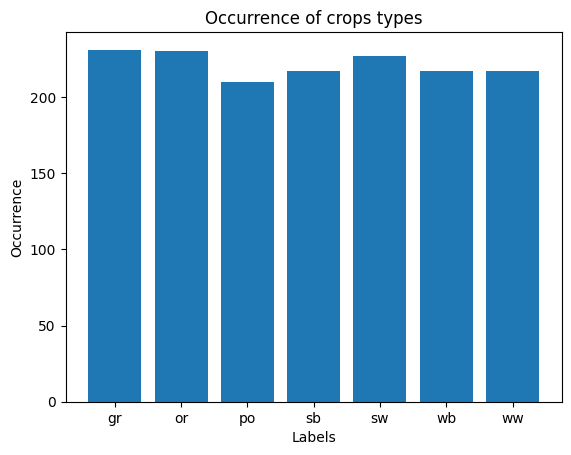

In [8]:
# print info
DS.print_info()

Size of training set : 1239 / 1549
Size of testing set : 310 / 1549


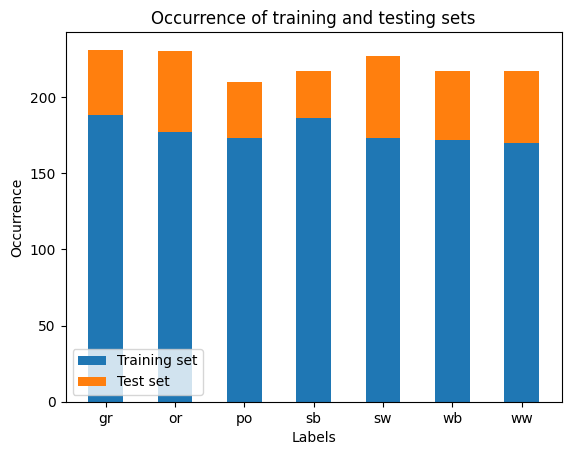

In [9]:
# separate train test
DS.separate_train_test(0.2)

## SVM

In [67]:
from sklearn import svm
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for ker in kernels:
  print()
  print('Kernel: ' + ker)
  clf = svm.SVC(kernel=ker)
  clf.fit(DS.stats_train, DS.cropcode_train)
  t = time.process_time()
  print( 'processing time : ' + str (round((time.process_time() - t),2)))
  print('Accuracy on training set= ' +  str(round(clf.score(DS.stats_train, DS.cropcode_train),2)));
  print('Accuracy on testing set= ' +  str(round(clf.score(DS.stats_test, DS.cropcode_test),2)));


Kernel: linear
processing time : 0.0
Accuracy on training set= 0.52
Accuracy on testing set= 0.54

Kernel: poly
processing time : 0.0
Accuracy on training set= 0.32
Accuracy on testing set= 0.32

Kernel: rbf
processing time : 0.0
Accuracy on training set= 0.4
Accuracy on testing set= 0.39

Kernel: sigmoid
processing time : 0.0
Accuracy on training set= 0.17
Accuracy on testing set= 0.16


Overall Accuracy : 0.5270  (misclass =0.4730)
Cohen's Coefficient : 0.4611


,precison,recall,f1
sw,0.510638,0.444444,0.475248
or,0.823529,0.528302,0.643678
ww,0.463415,0.404255,0.431818
gr,0.391304,0.627907,0.482143
sb,0.117647,0.129032,0.123077
po,0.676471,0.621622,0.647887
wb,0.823529,0.933333,0.875000


total precision : 0.7
total recall : 0.68
total f1 : 0.69


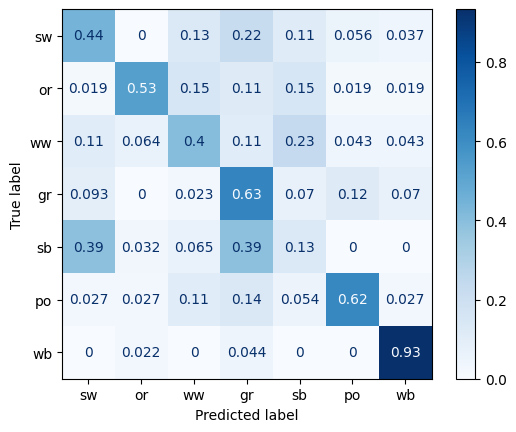

In [75]:
ker = 'linear' #best kernel
clf = svm.SVC(kernel=ker)
clf.fit(DS.stats_train, DS.cropcode_train)
prediction = clf.predict(DS.stats_test)

# confusion matrix and accuracy metrics
conf_mx, df, accuracy, kappa = accuracy_metrics(DS.cropcode_test, prediction, DS.class_names)

In [12]:
SaveRes(conf_mx, df, accuracy, kappa, DS.class_names, 'results/SVM/result_svm_21_01_jul', ['SVM', 'kernel='+ker])

## RF


 87% (7 of 8) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00

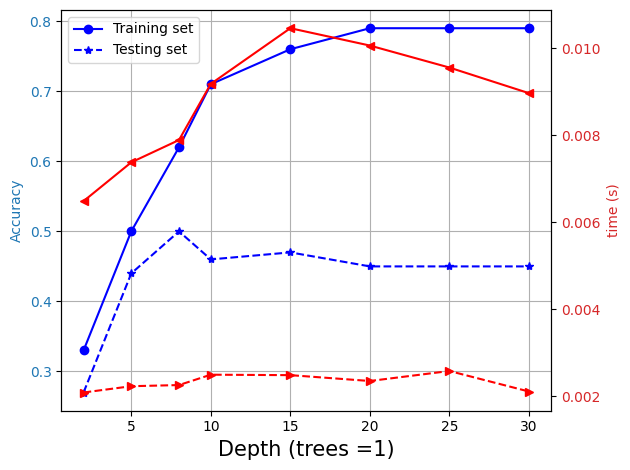

100% (8 of 8) |##########################| Elapsed Time: 0:00:01 ETA:  00:00:00

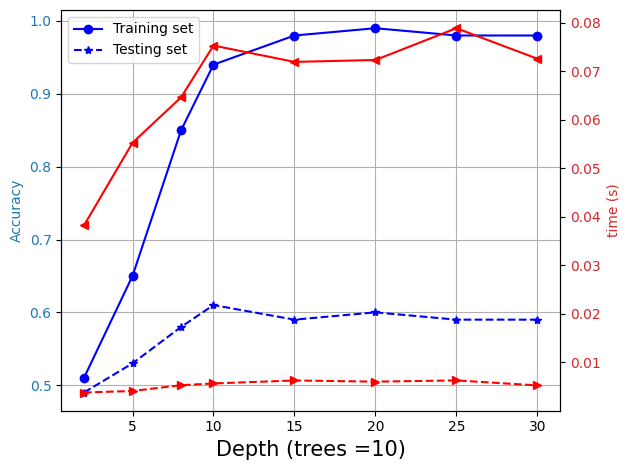

100% (8 of 8) |##########################| Elapsed Time: 0:00:01 ETA:  00:00:00



final testing values =  [0.6, 0.6]


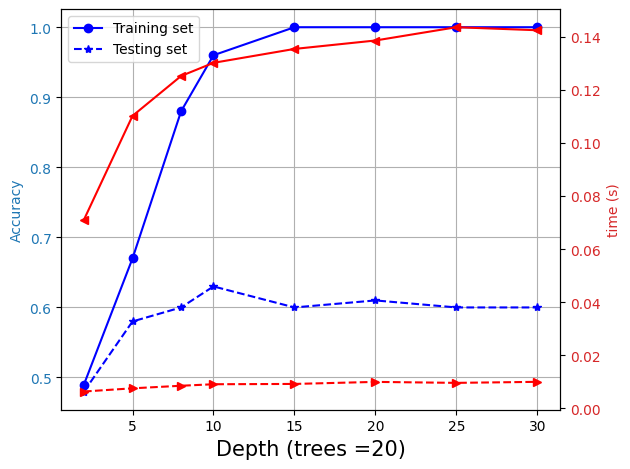

100% (8 of 8) |##########################| Elapsed Time: 0:00:02 ETA:  00:00:00



final testing values =  [0.64, 0.64]


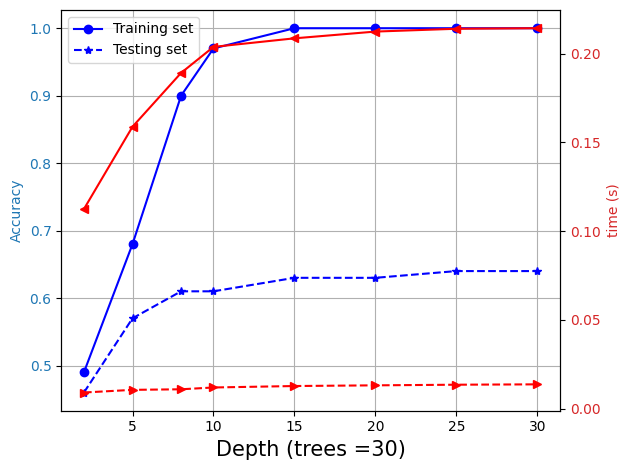

100% (8 of 8) |##########################| Elapsed Time: 0:00:03 ETA:  00:00:00



final testing values =  [0.64, 0.64]


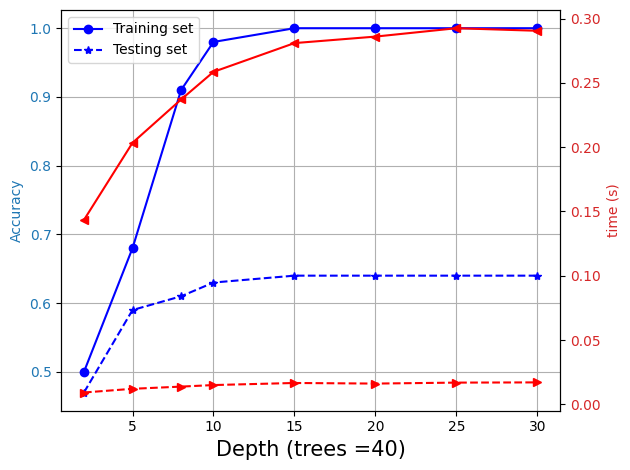

In [13]:
from sklearn.ensemble import RandomForestClassifier

depths = [2,5,8,10,15,20,25,30]
trees = [1, 10, 20, 30, 40]


for s in trees:
  idx = 0;
  score_training = [0.0 for i in range(len(depths))]
  score_testing  = [0.0 for i in range(len(depths))]
  time_train  = [0.0 for i in range(len(depths))]
  time_test  = [0.0 for i in range(len(depths))]
  bar = progressbar.ProgressBar(maxval=len(depths)).start()
  for d in depths:
    clf = RandomForestClassifier(max_depth=d, random_state=0, n_estimators=s)
    t = time.process_time()
    clf.fit(DS.stats_train, DS.cropcode_train)
    time_train[idx] = time.process_time() - t
    score_training[idx] = round(clf.score(DS.stats_train, DS.cropcode_train),2);
    time_test[idx] = time.process_time() - t - time_train[idx]
    score_testing[idx] = round(clf.score(DS.stats_test, DS.cropcode_test),2);
    idx +=1;
    bar.update(idx)

  if (score_training[-2:] == [1.0, 1.0]):
    print('\n')
    print('final testing values = ', score_testing[-2:])

  fig, ax1 = plt.subplots()

  color = 'tab:blue'
  ax1.set_xlabel('Depth (trees ='+str(s)+')', fontsize=15,)
  ax1.set_ylabel('Accuracy', color=color)
  ax1.plot(depths, score_training, '-bo', label='Training set')
  ax1.plot(depths, score_testing, '--b*', label='Testing set')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.grid()
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:red'

  ax2.set_ylabel('time (s)', color=color)
  ax2.plot(depths, time_train, '-r<', label='Training set')  # we already handled the x-label with ax1
  ax2.plot(depths, time_test, '--r>', label='Testing set')  # we already handled the x-label with ax1
  ax2.tick_params(axis='y', labelcolor=color)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped

  plt.show()


Overall Accuracy : 0.6249  (misclass =0.3751)
Cohen's Coefficient : 0.5737


,precison,recall,f1
sw,0.564103,0.407407,0.473118
or,0.795918,0.735849,0.764706
ww,0.641509,0.723404,0.680000
gr,0.547170,0.674419,0.604167
sb,0.289474,0.354839,0.318841
po,0.724138,0.567568,0.636364
wb,0.836735,0.911111,0.872340


total precision : 0.76
total recall : 0.78
total f1 : 0.77


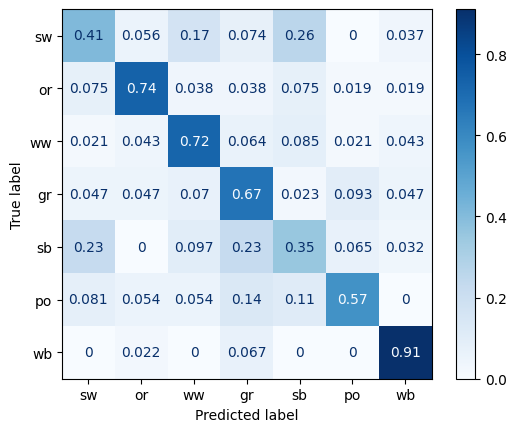

In [76]:
s = 30 # best number of trees
d = 25 # best depth

clf = RandomForestClassifier(max_depth=d, random_state=0, n_estimators=s)
clf.fit(DS.stats_train, DS.cropcode_train)
prediction = clf.predict(DS.stats_test)

# confusion matrix and accuracy metrics
conf_mx, df, accuracy, kappa = accuracy_metrics( DS.cropcode_test, prediction, DS.class_names)

In [15]:
SaveRes(conf_mx, df, accuracy, kappa, DS.class_names, 'results/RF/result_srf_21_01_jul', ['random forest', 'depth='+str(d), 'trees='+str(s)])